In [1]:
#include <lodepng_config_cling.h>
#include <vtkm_config_cling.h>
#include <iostream>
#include <string>

In [2]:
#include <vtkm/cont/DeviceAdapter.h>
#include <vtkm/cont/testing/MakeTestDataSet.h>
#include <vtkm/cont/testing/Testing.h>
#include <vtkm/rendering/Actor.h>
#include <vtkm/rendering/CanvasRayTracer.h>
#include <vtkm/rendering/MapperWireframer.h>
#include <vtkm/rendering/MapperRayTracer.h>
#include <vtkm/rendering/Scene.h>
#include <vtkm/rendering/View3D.h>
#include <vtkm/rendering/testing/RenderTest.h>


Use lodepng to save out png instead of pnm so jupyter can read it.


In [3]:
#include <lodepng.h>
template<typename CanvasType>
void convertPng(CanvasType &canvas, std::vector<std::uint8_t> &ImageBuffer)
{
    int width = canvas.GetWidth();
    int height = canvas.GetHeight();
  std::vector<std::uint8_t> PngBuffer(width*height*4);

  using ColorBufferType = vtkm::cont::ArrayHandle<vtkm::Vec<vtkm::Float32, 4>>;

  ColorBufferType::PortalConstControl colorPortal = canvas.GetColorBuffer().GetPortalConstControl();

  for (vtkm::Id yIndex = 0; yIndex < height; yIndex++)
  {
    for (vtkm::Id xIndex = 0; xIndex < width; xIndex++)
    {
      vtkm::Vec<vtkm::Float32, 4> tuple = colorPortal.Get(yIndex * width + xIndex);
      //of << (unsigned char)(tuple[0] * 255);
      //of << (unsigned char)(tuple[1] * 255);
      //of << (unsigned char)(tuple[2] * 255);
        
        std::size_t NewPos = (height - yIndex - 1) * (width * 4) + 4 * xIndex;
        PngBuffer[NewPos + 0] = (unsigned char)(tuple[0] * 255);
        PngBuffer[NewPos + 1] = (unsigned char)(tuple[1] * 255);
        PngBuffer[NewPos + 2] = (unsigned char)(tuple[2] * 255);
        PngBuffer[NewPos + 3] = 255; 

    }
  }
  lodepng::encode(ImageBuffer, PngBuffer, width, height);
//lodepng::save_file(ImageBuffer, fn.c_str());    
}



In [4]:
#include <string>
#include <fstream>

#include "xtl/xbase64.hpp"
#include "nlohmann/json.hpp"

namespace im
{
    struct image
    {
        inline image(){}
        inline image(const std::vector<uint8_t> &png)
        {
            m_buffer.assign(png.begin(), png.end());
        }

        std::string m_buffer;
    };

    nlohmann::json mime_bundle_repr(const image& i)
    {
        auto bundle = nlohmann::json::object();
        bundle["image/png"] = xtl::base64encode(i.m_buffer);
        return bundle;
    }
}

std::unique_ptr<im::image> displayImage = std::unique_ptr<im::image>();


In [5]:
template <typename ViewType>
inline void SetCamera(vtkm::rendering::Camera& camera,
                      const vtkm::Bounds& coordBounds,
                      const vtkm::cont::Field& field);

template <>
inline void SetCamera<vtkm::rendering::View3D>(vtkm::rendering::Camera& camera,
                                               const vtkm::Bounds& coordBounds,
                                               const vtkm::cont::Field&)
{
  camera = vtkm::rendering::Camera();
  camera.ResetToBounds(coordBounds);
  camera.Azimuth(static_cast<vtkm::Float32>(45.0));
  camera.Elevation(static_cast<vtkm::Float32>(45.0));
}
template <typename MapperType, typename CanvasType, typename ViewType>
void Render(ViewType& view)
{
  view.Initialize();
  view.Paint();
}


In [6]:
#include <xcpp/xdisplay.hpp>
auto id = xeus::new_xguid();
static bool first = true;


In [7]:

void Render(vtkm::cont::DataSet ds)
{
    using M = vtkm::rendering::MapperRayTracer;
    using C = vtkm::rendering::CanvasRayTracer;
    using V3 = vtkm::rendering::View3D;

    vtkm::cont::ColorTable colorTable("inferno");

    M mapper;
    C canvas(512, 512);
    vtkm::rendering::Scene scene;
    static std::string fieldNm = "pointvar";

    scene.AddActor(vtkm::rendering::Actor(
    ds.GetCellSet(), ds.GetCoordinateSystem(), ds.GetField(fieldNm), colorTable));
    vtkm::rendering::Camera camera;
    SetCamera<V3>(camera, ds.GetCoordinateSystem().GetBounds(), ds.GetField(fieldNm));
    vtkm::rendering::Color background(0.0f, 1.0f, 1.0f, 1.0f);
    vtkm::rendering::Color foreground(0.0f, 0.0f, 0.0f, 1.0f);
    V3 view(scene, mapper, canvas, camera, background, foreground);

    // Print the title
//     vtkm::rendering::TextAnnotationScreen* titleAnnotation =
//     new vtkm::rendering::TextAnnotationScreen("Test Plot",
//                                               vtkm::rendering::Color(1, 1, 1, 1),
//                                               .075f,
//                                               vtkm::Vec<vtkm::Float32, 2>(-.11f, .92f),
//                                               0.f);
//     view.AddAnnotation(titleAnnotation);

    //render over and over again to the same position on the page
    Render<M, C, V3>(view);
    std::vector<std::uint8_t> png;
    convertPng(canvas, png);
    displayImage = std::make_unique<im::image>(png);
    xcpp::display(*displayImage, id, !first);        

    first = false;

}

In [8]:
#pragma cling add_library_path("/opt/adios2/lib")
#pragma cling add_library_path("/usr/lib")
#pragma cling add_library_path("/home/adios/.conda/envs/cling/lib/")
#pragma cling add_include_path("/opt/adios2/include")
#pragma cling add_include_path("/usr/include/mpi")
#pragma cling load("adios2")
#pragma cling load("mpi")
#pragma cling load("mpi_cxx")

#include <adios2.h>
#include <mpi.h>

#include <memory.h>

#include <xcpp/xdisplay.hpp>
#include <xwidgets/xbutton.hpp>


const int phiMultiplier = 8;
int numNodes, numTris, numPhi, numTimeSteps;

bool running = true;
std::unique_ptr<xw::button> button = std::unique_ptr<xw::button>();
std::unique_ptr<adios2::IO> fileIO;
std::unique_ptr<adios2::IO> meshIO;

std::unique_ptr<adios2::Engine> fileReader, meshReader;

vtkm::cont::ArrayHandle<vtkm::Id> wedgeConn;
  vtkm::cont::ArrayHandle<vtkm::Vec<double,3>> points;


In [9]:

void initializeReaders(std::string meshName)
{
    fileReader->BeginStep(adios2::StepMode::NextAvailable, 0.0f);

    meshReader = std::make_unique<adios2::Engine>(meshIO->Open(meshName, adios2::Mode::Read));
    
    adios2::Variable<int> nVar = meshIO->InquireVariable<int>("n_n");
    adios2::Variable<int> triVar = meshIO->InquireVariable<int>("n_t");
    adios2::Variable<int> phiVar = fileIO->InquireVariable<int>("nphi");

    if (nVar){
        meshReader->Get(nVar, &numNodes, adios2::Mode::Sync);

    }
    if (triVar)
        meshReader->Get(triVar, &numTris, adios2::Mode::Sync);

    if (phiVar){
        fileReader->Get(phiVar, &numPhi, adios2::Mode::Sync);
        std::cout << "phi: " << numPhi << std::endl;
    }
}

In [10]:
vtkm::cont::DataSet readMesh(
             std::unique_ptr<adios2::IO> &meshIO,
             std::unique_ptr<adios2::Engine> &meshReader)
{
    
    std::cout << "numNodes: " << numNodes << ", numTris " << numTris << ", numPhi " << numPhi << std::endl;
   adios2::Variable<double> coordVar = meshIO->InquireVariable<double>("/coordinates/values");

  std::vector<double> buff;

  //const int newPhi = phiMultiplier * numPhi;
    int newPhi = numPhi;

   meshReader->Get(coordVar, buff, adios2::Mode::Sync);

   auto coords = vtkm::cont::make_ArrayHandle(buff);
  std::vector<int> ibuffc, ibuffn;

  //vtkDataArray *conn = NULL, *nextNode = NULL;
  // meshFile->ReadScalarData("/cell_set[0]/node_connect_list", timestate, &conn);
  // if (!meshFile->ReadScalarData("/nextnode", timestate, &nextNode))
  //     meshFile->ReadScalarData("nextnode", timestate, &nextNode);
  auto nodeConnectorVar = meshIO->InquireVariable<int>("/cell_set[0]/node_connect_list");
  auto nextNodeVar = meshIO->InquireVariable<int>("nextnode");
  if (!nodeConnectorVar || !nextNodeVar)
      return vtkm::cont::DataSet();

  meshReader->Get(nodeConnectorVar, ibuffc,adios2::Mode::Sync);
  auto conn = vtkm::cont::make_ArrayHandle(ibuffc);

  meshReader->Get(nextNodeVar, ibuffn, adios2::Mode::Sync);
  if (ibuffn.size() < 1)
      return vtkm::cont::DataSet();

  auto nextNode = vtkm::cont::make_ArrayHandle(ibuffn);
  //Create the points.

     int numPlanes = numPhi;
    float dPhi =  2.0*M_PI/(float)(numPlanes);

    points.Allocate(numNodes * numPlanes);

    auto pointsPortal = points.GetPortalControl();
    auto coordsPortal = coords.GetPortalConstControl();
    for (int i = 0; i < numPlanes; i++)
    {
        float phi = (float)i * dPhi;
        for (int p = 0; p < numNodes; p++)
        {
            float R = coordsPortal.Get(p*2 +0);
            float Z = coordsPortal.Get(p*2 +1);
            
            vtkm::Vec<float,3> pt;
            pt[0] = R*cos(phi);
            pt[1] = R*sin(phi);
            pt[2] = Z;
            pointsPortal.Set(p+i*numNodes, pt);
        }
    }

    vtkm::Id numCells = (numPlanes)*numTris;

    wedgeConn.Allocate(numCells*6);
    auto wedgeConnPortal = wedgeConn.GetPortalControl();
    auto connPortal = conn.GetPortalConstControl();
    vtkm::Id j = 0;
    for (int i = 0; i < numPlanes-1; i++)
    {
        for (int p = 0; p < numTris*3; p+=3)
        {
            vtkm::Id off = i*numNodes;
            vtkm::Id p0 = connPortal.Get(p+0);
            vtkm::Id p1 = connPortal.Get(p+1);
            vtkm::Id p2 = connPortal.Get(p+2);
            wedgeConnPortal.Set(j+0, p0+off);
            wedgeConnPortal.Set(j+1, p1+off);
            wedgeConnPortal.Set(j+2, p2+off);
            
            off = (i+1) * numNodes;
            vtkm::Id p3 = p0+off;
            vtkm::Id p4 = p1+off;
            vtkm::Id p5 = p2+off;
            wedgeConnPortal.Set(j+3, p3);
            wedgeConnPortal.Set(j+4, p4);
            wedgeConnPortal.Set(j+5, p5);
            j += 6;
        }
    }
    
    int i = numPlanes - 1;
    for (int p = 0; p < numTris*3; p+=3)
        {
            vtkm::Id p0 = connPortal.Get(p+0);
            vtkm::Id p1 = connPortal.Get(p+1);
            vtkm::Id p2 = connPortal.Get(p+2);
        
            vtkm::Id p3 = p0;
            vtkm::Id p4 = p1;
            vtkm::Id p5 = p2;
            vtkm::Id off = i * numNodes;
            wedgeConnPortal.Set(j+0, p0 + off);
            wedgeConnPortal.Set(j+1, p1 + off);
            wedgeConnPortal.Set(j+2, p2 + off);
            wedgeConnPortal.Set(j+3, p3);
            wedgeConnPortal.Set(j+4, p4);
            wedgeConnPortal.Set(j+5, p5);
            j += 6;
        }
    vtkm::cont::DataSetBuilderExplicit builder;
    vtkm::cont::DataSet ds;
    ds = builder.Create(points, vtkm::CellShapeTagWedge(), 6, wedgeConn);

    
//     std::vector<int> numPhiVec = {0};
//     numPhiVec[0] = newPhi;

//     vtkm::cont::ArrayHandle<vtkm::Int32> tmpArray = vtkm::cont::make_ArrayHandle(numPhiVec);
//     vtkm::cont::ArrayHandle<vtkm::Int32> phiHandle;
//     vtkm::cont::ArrayCopy(tmpArray, phiHandle);

//     ds.AddField(vtkm::cont::Field("numPhi", vtkm::cont::Field::Association::WHOLE_MESH, phiHandle));

//     std::vector<float> vars(pointsPortal.GetNumberOfValues());
//     for (int i=0; i<vars.size(); i++){
//         vars[i] = float(i)/vars.size();
//     }
        
//     std::cout << vars[vars.size()/2] << std::endl;
//       ds.AddField(vtkm::cont::Field("pointvar", 
//                                     vtkm::cont::Field::Association::POINTS, 
//                                     vars.size(), 
//                                     vtkm::cont::make_ArrayHandle(vars, vtkm::CopyFlag::On)));

    return ds;

}

In [11]:
vtkm::cont::DataSet 
readValues()
{
    vtkm::cont::DataSetBuilderExplicit builder;
    vtkm::cont::DataSet ds;
    ds = builder.Create(points, vtkm::CellShapeTagWedge(), 6, wedgeConn);

    auto var = fileIO->InquireVariable<double>("dpot");
    std::vector<double> buff;
    fileReader->Get(var, buff,adios2::Mode::Sync);
    auto dpot = vtkm::cont::make_ArrayHandle(buff);

    ds.AddField(vtkm::cont::Field("pointvar", vtkm::cont::Field::Association::POINTS,
                                 buff.size(),
                                 dpot));
    
    return ds;
}

In [12]:
void setupbutton()
{
    button = std::make_unique<xw::button>();
    button->description = "stop";
    button->on_click([](){running = !running; button->description = running? "stop":"start";});
    button->display();
}


A Jupyter widget

Open /home/adios/Tutorial/xgc/totalf_itg_tiny/xgc.3d.bp
input_line_24 22
0
phi: 4
numNodes: 20694, numTris 41087, numPhi 4


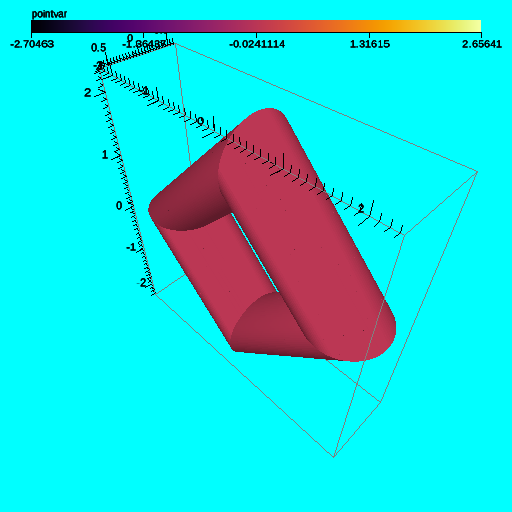

In [ ]:

[](){
auto try_and_err = []() {

    
    MPI_Init(NULL,NULL);

    //std::future the_answer=std::async(setupbutton);
    setupbutton();

    adios2::ADIOS adios(MPI_COMM_WORLD);
    adios2::ADIOS mesh(MPI_COMM_WORLD);
    
    int numTimeSteps;
    
    std::string filename("/home/adios/Tutorial/xgc/totalf_itg_tiny/xgc.3d.bp");
    fileIO = std::make_unique<adios2::IO>(adios.DeclareIO("SST"));
    fileIO->SetEngine("SST");
    meshIO = std::make_unique<adios2::IO>(mesh.DeclareIO("BP"));
    meshIO->SetEngine("BP");    
    
    
    fileReader = std::make_unique<adios2::Engine>(fileIO->Open(filename, adios2::Mode::Read));

    std::cout<<"Open "<<filename<<std::endl;
    std::cout<<__FILE__<<" "<<__LINE__<<std::endl;

    const auto variables = fileIO->AvailableVariables();
    std::cout << variables.size() << std::endl;
    
      for (const auto variablePair : variables)
      {
          std::cout << "Name: " << variablePair.first;

          for (const auto &parameter : variablePair.second)
          {
              std::cout << "\t" << parameter.first << ": " << parameter.second
                          << "\n";
          }
      }

//     if (coordVar)
//       return NULL;
    vtkm::cont::DataSet ds;
     initializeReaders("/home/adios/Tutorial/xgc/totalf_itg_tiny/xgc.mesh.bp");
    if (fileReader->BeginStep() == adios2::StepStatus::OK){
        ds = readMesh(meshIO, meshReader);        
        fileReader->EndStep();
    }
    try{
        while(fileReader->BeginStep() ==adios2::StepStatus::OK && running){
            ds = readValues();
            Render(ds);
//             std::cout<<__FILE__<<" "<<__LINE__<<std::endl;
//             auto variables = fileIO->AvailableVariables();
//             std::cout<<__FILE__<<" "<<__LINE__<<std::endl;

//             if (variables.size() > 0)
//             {
//                 auto var0 = variables.begin()->second;
//                 std::string nsteps = var0["AvailableStepsCount"];
//                 numTimeSteps = std::stoi(nsteps);
//             }

//             for (auto &v : variables)
//                 std::cout<<"Var: "<<v.first<<std::endl;

             fileReader->EndStep();
        }
    
        fileReader->Close();
    
        MPI_Finalize();
    }
    catch(int e){
        fileReader->EndStep();
        fileReader->Close();
        MPI_Finalize();
    }

};
try_and_err();
}();